In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras import layers, models, callbacks, optimizers
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import math

In [2]:
path = '/Users/HP Spectre/OneDrive - student.kit.edu/uni/Master/Lissabon Kurse/Intelligent Systems/IntSysGroup6/'

data = pd.read_csv(path+'Project/data/robot_inverse_kinematics_dataset_own.csv')

X = data.iloc[:, 6:].to_numpy()
q1 = data.iloc[:, 0:1].to_numpy()
q3 = data.iloc[:, 2:3].to_numpy()

scaler_X = MinMaxScaler()
scaler_q1 = MinMaxScaler()
scaler_q3 = MinMaxScaler()
X = scaler_X.fit_transform(X)
q1 = scaler_q1.fit_transform(q1)
q3 = scaler_q3.fit_transform(q3)

X_train, X_test, q1_train, q1_test = train_test_split(X, q1, random_state=42, test_size=0.2)
X_train, X_test, q3_train, q3_test = train_test_split(X, q3, random_state=42, test_size=0.2)

In [3]:
def train_and_evaluate_model(X_train, y_train, name, X_test, y_test,scaler_Y):
    model = tf.keras.Sequential([
        layers.Input(shape=(3,)),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(100, activation='relu'),
        layers.Dense(1)
    ])


    initial_learning_rate = 0.001
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,  # Adjust this value
        decay_rate=0.5,  # Adjust this value
        staircase=True
    )

    callbacks.LearningRateScheduler(lr_schedule)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=lr_schedule,
                                            weight_decay=0.01))

    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )

    history = model.fit(
              X_train,
              y_train,
              validation_split=0.2,
              verbose=1,
              epochs=30,
              callbacks=[early_stopping])

    y_pred = model.predict(X_test)
    print(f"MAE for {name}: ", mean_absolute_error(y_test, y_pred))
    y_pred = scaler_Y.inverse_transform(y_pred)
    y_test = scaler_Y.inverse_transform(y_test)
    print(f"MAE for {name} in deg: ", mean_absolute_error(np.degrees(y_test), np.degrees(y_pred)))
    print(f"MAE for {name} in deg: ", math.degrees(mean_absolute_error(y_test, y_pred)))

    r2 = r2_score(y_test, y_pred)
    print(f"R-squared (R2) Score for {name}: {r2}")
    
    if name == 'q3':
        full_prediction_q3 = model.predict(X)
        full_prediction_q3 = scaler_Y.inverse_transform(full_prediction_q3)
        results_qf = pd.DataFrame({'q3_pred': full_prediction_q3.flatten()})
        # Save the predictions to a CSV file
        results_filename = "Project/saved_pred/q3_pred_own.csv"
        results_qf.to_csv(path+results_filename, index=False)


    return r2,history, math.degrees(mean_absolute_error(y_test, y_pred))





# Train and evaluate models for q1 and q3
r2_q1, history_q1, mae_q1 = train_and_evaluate_model(X_train, q1_train, "q1", X_test, q1_test,scaler_q1)

r2_q3,history_q3, mae_q3 = train_and_evaluate_model(X_train, q3_train, "q3", X_test, q3_test,scaler_q3)


Epoch 1/30
100/100 [==============================] - 2s 5ms/step - loss: 0.0980 - val_loss: 0.0719
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0663 - val_loss: 0.0589
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0619 - val_loss: 0.0588
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0594 - val_loss: 0.0591
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0570 - val_loss: 0.0571
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0567 - val_loss: 0.0533
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0549 - val_loss: 0.0512
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0512
Epoch 9/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0522 - val_loss: 0.0517
Epoch 10/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0524 - val_loss: 0.0486

In [4]:
print(f"MAE for q1 in deg {mae_q1} and R^2 {r2_q1}")
print(f"MAE for q3 in deg {mae_q3}and R^2 {r2_q3}")

MAE for q1 in deg 15.55119759584898 and R^2 0.43867525510415795
MAE for q3 in deg 14.62756771364242and R^2 0.45984357109770413


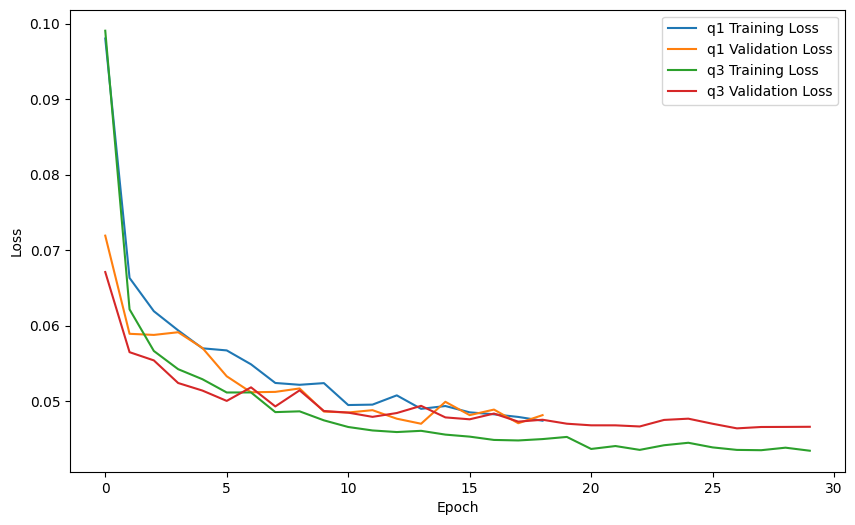

In [5]:
# Train and evaluate models for q1 and q3
histories_q1 = []
histories_q1.append(history_q1)
histories_q3 = []
histories_q3.append(history_q3)

# Plot loss curves for all runs
plt.figure(figsize=(10, 6))
for history in histories_q1:
    plt.plot(history.history['loss'], label='q1 Training Loss')
    plt.plot(history.history['val_loss'], label='q1 Validation Loss')
for history in histories_q3:
    plt.plot(history.history['loss'], label='q3 Training Loss')
    plt.plot(history.history['val_loss'], label='q3 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()